In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

# **Problem 1: Euler's Method**


In [2]:
"""
The derivative function
"""
def derivative(t):
  return -2 * math.exp(-4 * t) + math.exp(-2 * t)

"""
The actual function
"""
def function(t):
  return 1 + (1/2) * math.exp(-4 * t) - (1/2) * math.exp(-2 * t)

### **b)**

In [20]:
"""
This function calculates Euler's method integration.
"""
def euler_method(derivative, target_value, initial_condition_value, h = .001):
  output = []
  x_values = [0]
  output.append(initial_condition_value)

  idx = 1
  t = 0

  while t <= target_value: # loop until we reach the highest value
    t += h

    x_values.append(t)
    output.append(output[idx - 1] + h * derivative(t))
    idx += 1


  return output, x_values

"""
This function is for calculating the actual values of y
"""
def actual_values(function, target_value, initial_condition_value, h = .001):
  output = []
  output.append(initial_condition_value)
  x_values = [0]

  # increment and loop over t
  t = 0

  while t <= target_value: # loop through until values are reached
    t += h
    x_values.append(t)
    output.append(function(t))

  return output, x_values

In [41]:
"""
This function automatically graphs euler's method with respect to the actual value
"""
def plot_euler_v_actual(euler_x, euler_y, actual_x, actual_y, title = "Method Comparisons"):
  plt.plot(euler_x, euler_y, color = 'blue', label = "Euler's Method", linestyle = "--")
  plt.plot(actual_x, actual_y, color = 'red', label = "Actual Value")
  plt.title(title)
  plt.xlabel("t")
  plt.ylabel("Value")
  plt.legend(loc = "upper left")
  plt.show()

In [62]:
euler_method_output, x_values = euler_method(derivative = derivative, target_value = 1, initial_condition_value= 1)
actual_method_output, actual_x_values = actual_values(function = function, target_value = 1, initial_condition_value= 1)

# testing
# plot_euler_v_actual(x_values, euler_method_output, actual_x_values, actual_method_output)

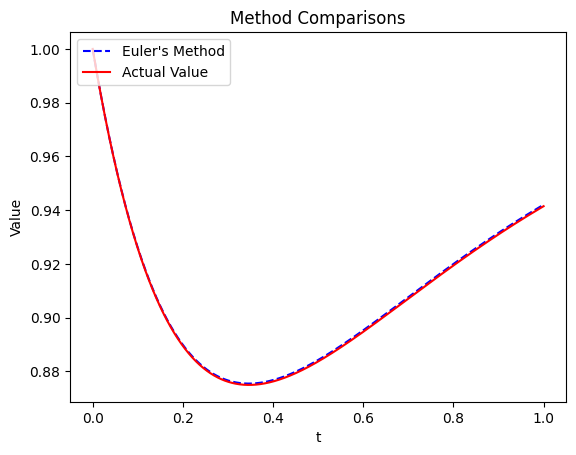

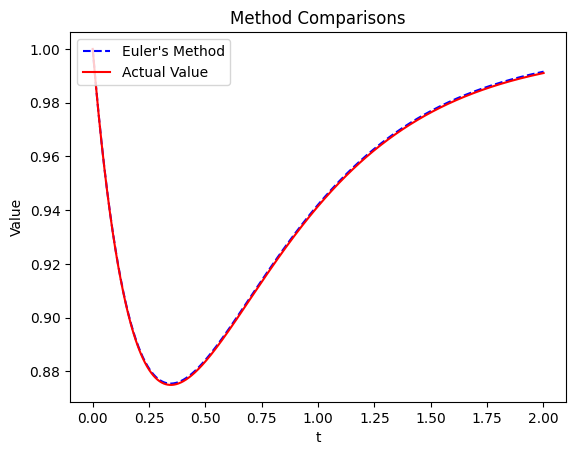

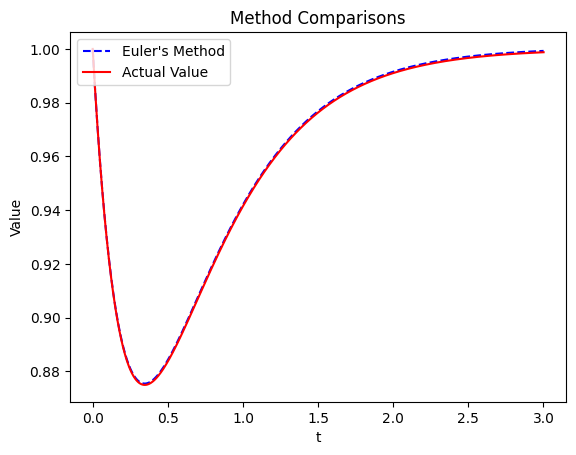

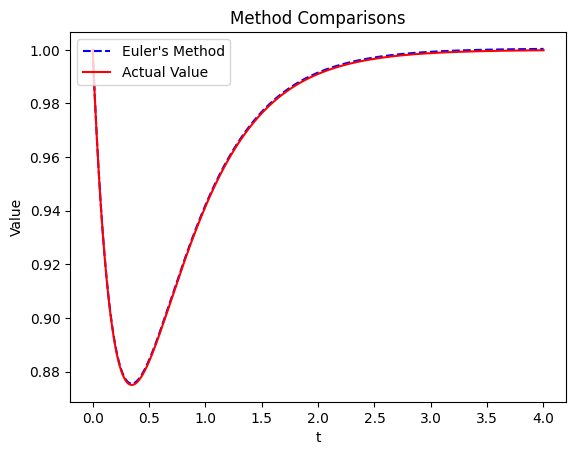

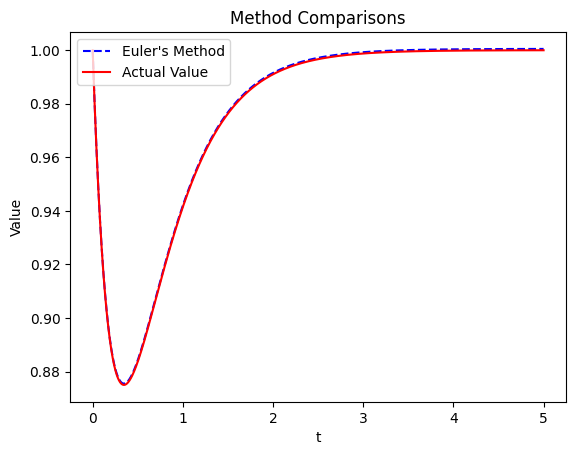

y(1) - Euler's Method: 0.9420390194835017, Actual Value: 0.9414901778260608
y(2) - Euler's Method: 0.9915358421949086, Actual Value: 0.9910275396198439
y(3) - Euler's Method: 0.9992668904011189, Actual Value: 0.9987661600290384
y(4) - Euler's Method: 1.0003323270849547, Actual Value: 0.9998326598564039
y(5) - Euler's Method: 1.00047682375621, Actual Value: 0.9999773010656955



In [63]:
t_list = {1, 2, 3, 4, 5} # list of solutions targets

euler_v_actual_string = "" # string for printing the table

for target_value in t_list: # loop through all target values
  # calculate the outputs
  euler_method_output, euler_x_values = euler_method(derivative = derivative, target_value = target_value, initial_condition_value = 1)
  actual_method_output, actual_x_values = actual_values(function = function, target_value = target_value, initial_condition_value = 1)

  euler_v_actual_string += f"y({target_value}) - Euler's Method: {euler_method_output[-1]}, Actual Value: {actual_method_output[-1]}\n"

  # plot the values
  plot_euler_v_actual(euler_x = euler_x_values, euler_y = euler_method_output,
                      actual_x = actual_x_values, actual_y = actual_method_output)

# print a table
print(euler_v_actual_string)

## **c)**

In [64]:
h_values = [.1, .05, .01, .005, .001] # try different h values

# plot the h_values with their respective t_values
def plot_t(h_values = [1], t = 1):

  fig = plt.figure(figsize = (50, 10))
  fig.suptitle(f"Euler's Method for t = {t}", fontsize = 16)

  # set the graph index
  idx = 1

  for h_value in h_values: # loop h-values
    fig.add_subplot(1, 5, idx)
    euler_method_output, euler_x_values = euler_method(derivative = derivative, target_value = t, initial_condition_value = 1, h = h_value)

    plt.plot(euler_x_values, euler_method_output, color = 'blue', label = "Euler's Method", linestyle = "--")
    plt.xlabel("t")
    plt.ylabel("Value")
    plt.title(f"h = {h_value}")


    # update the index
    idx += 1

# testing purposes
# plot_t(h_values = h_values)

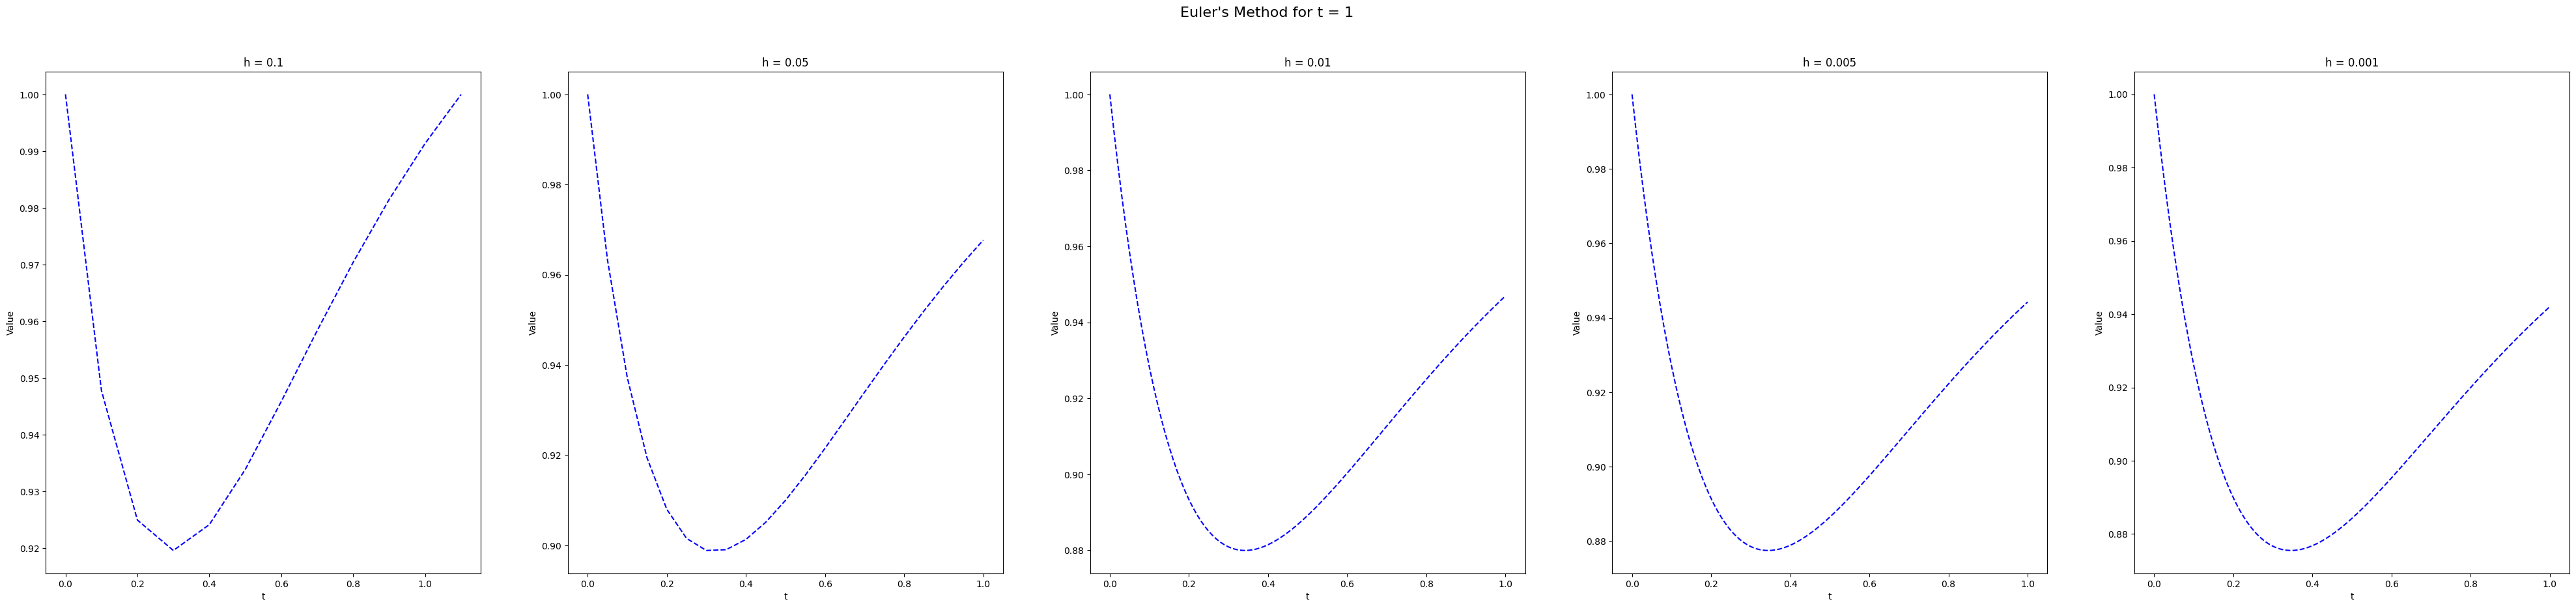

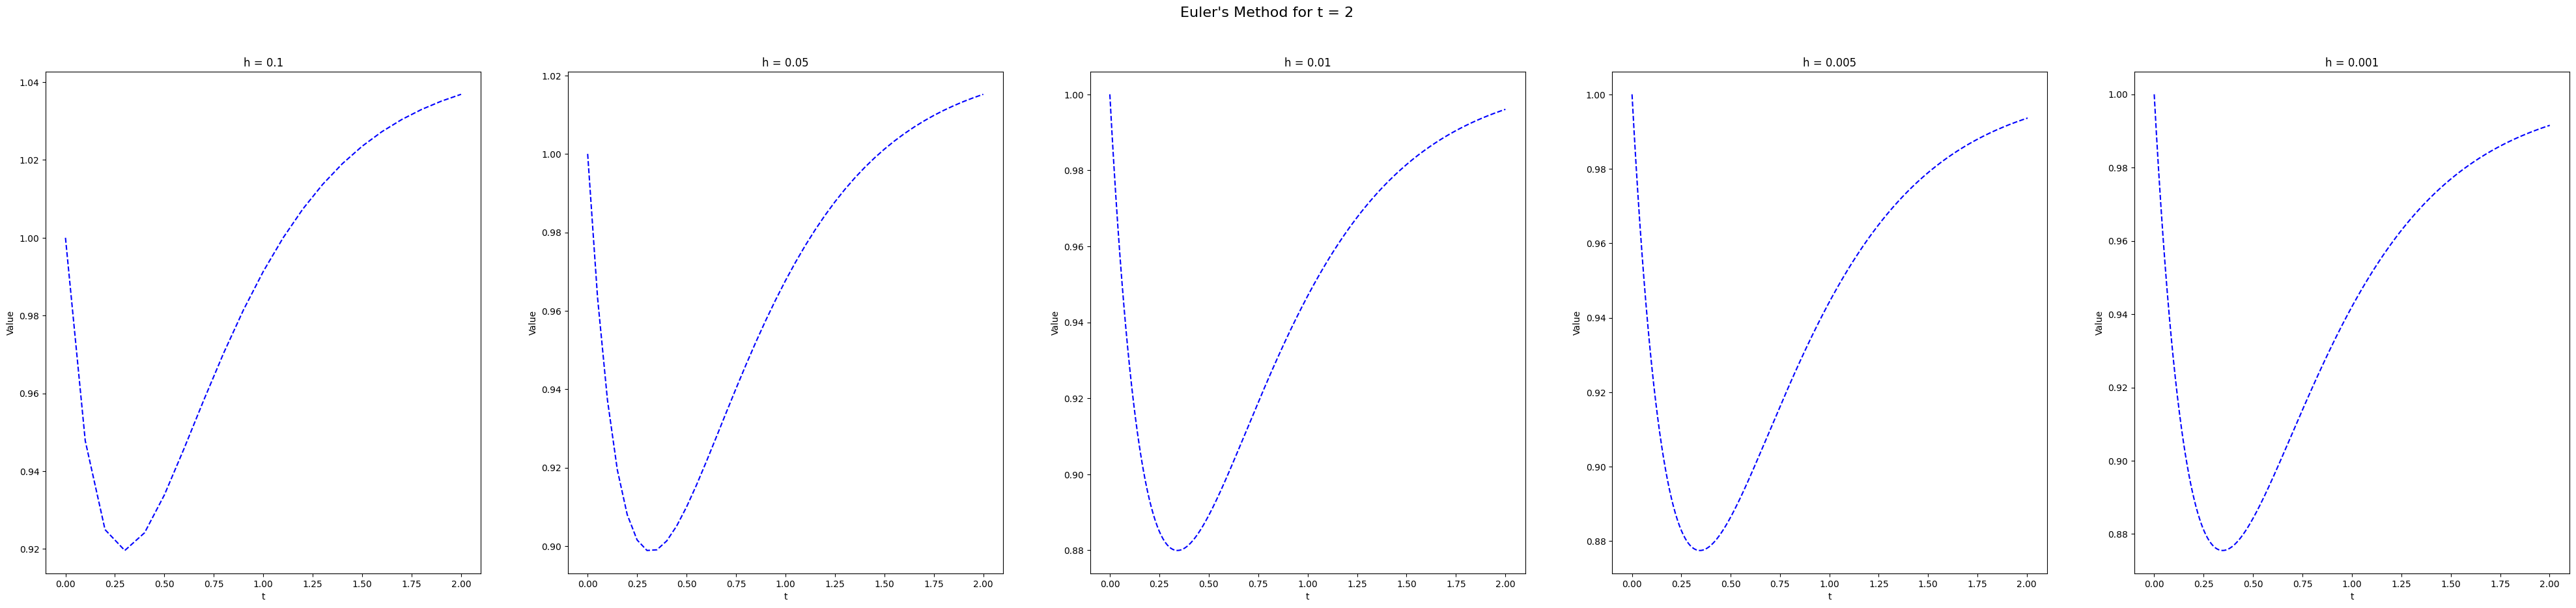

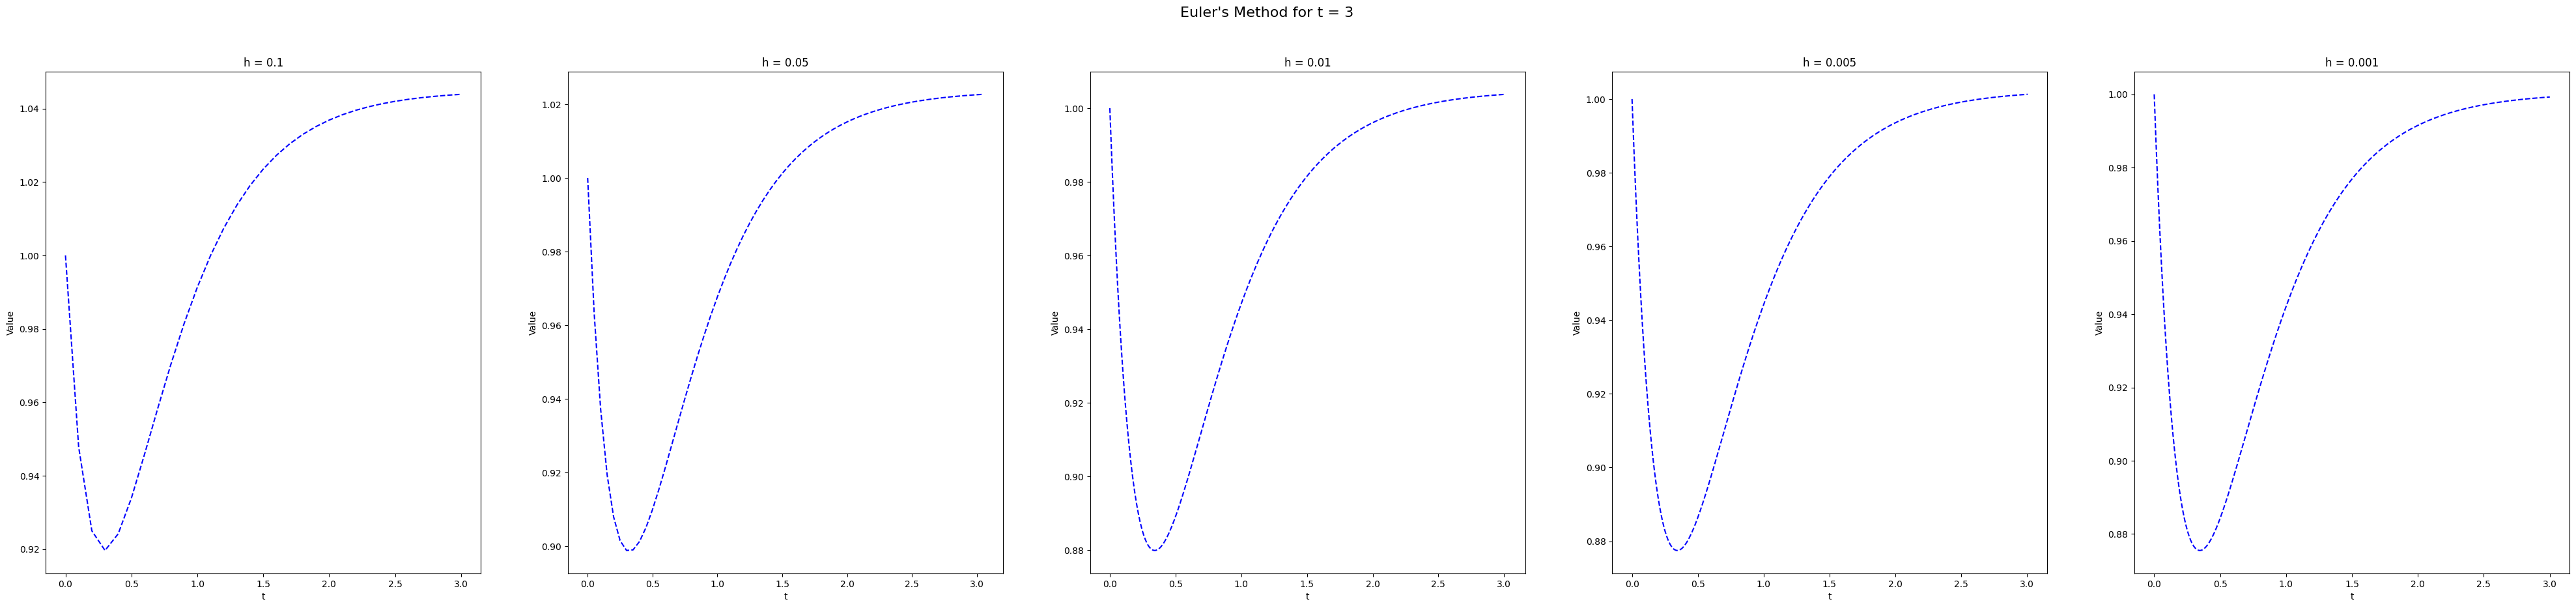

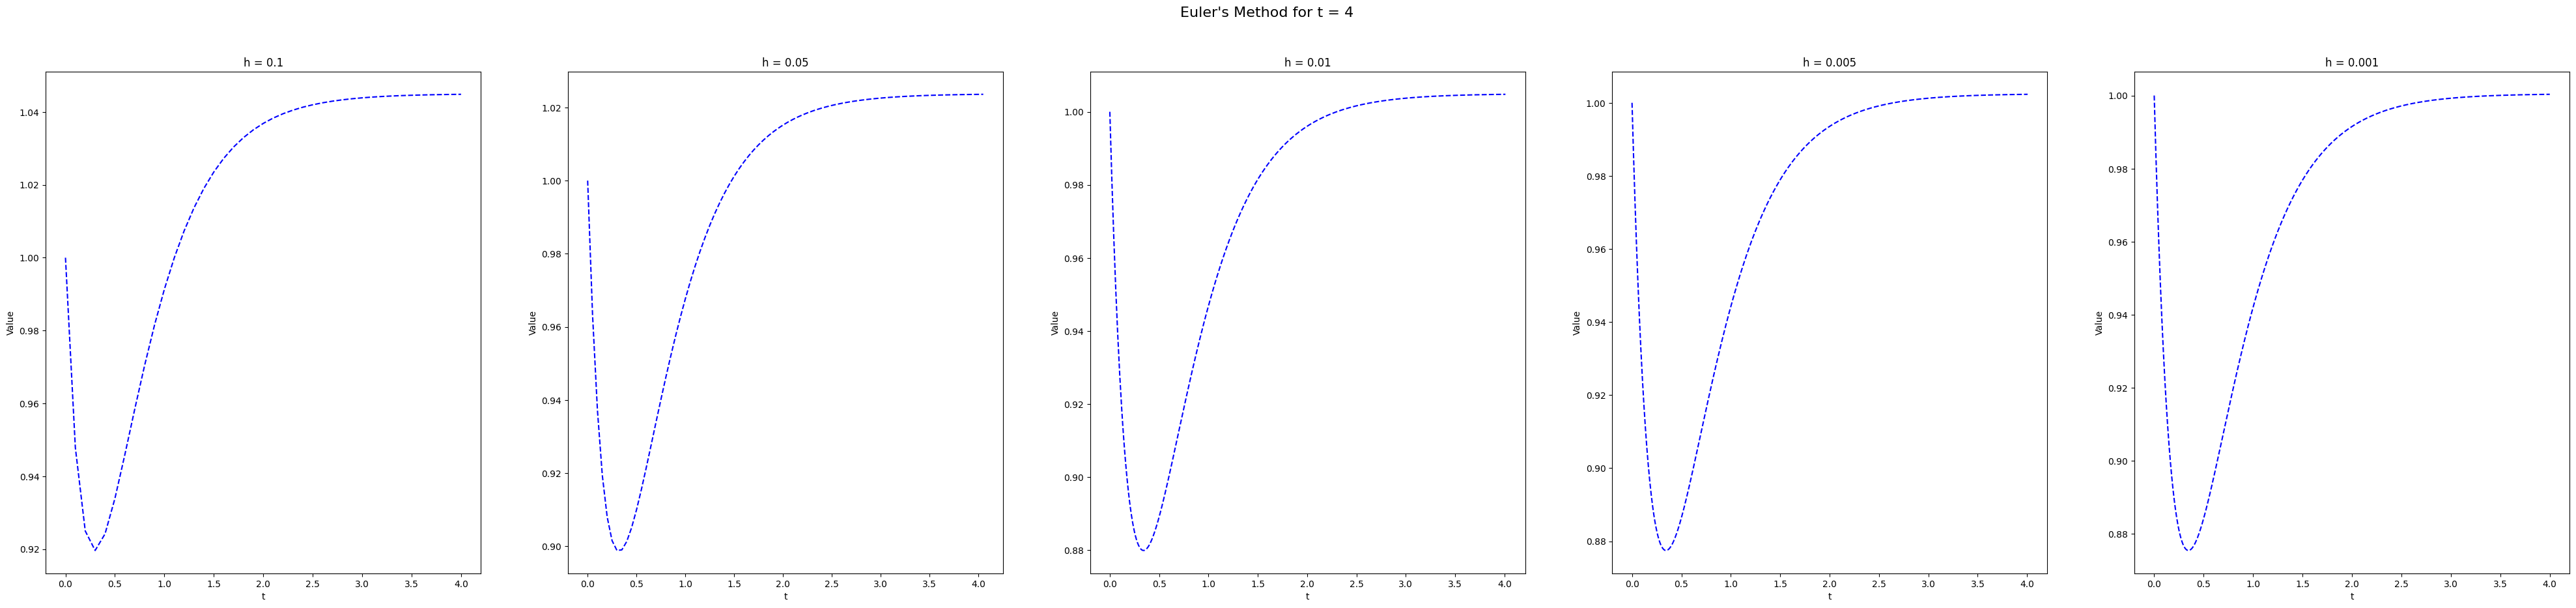

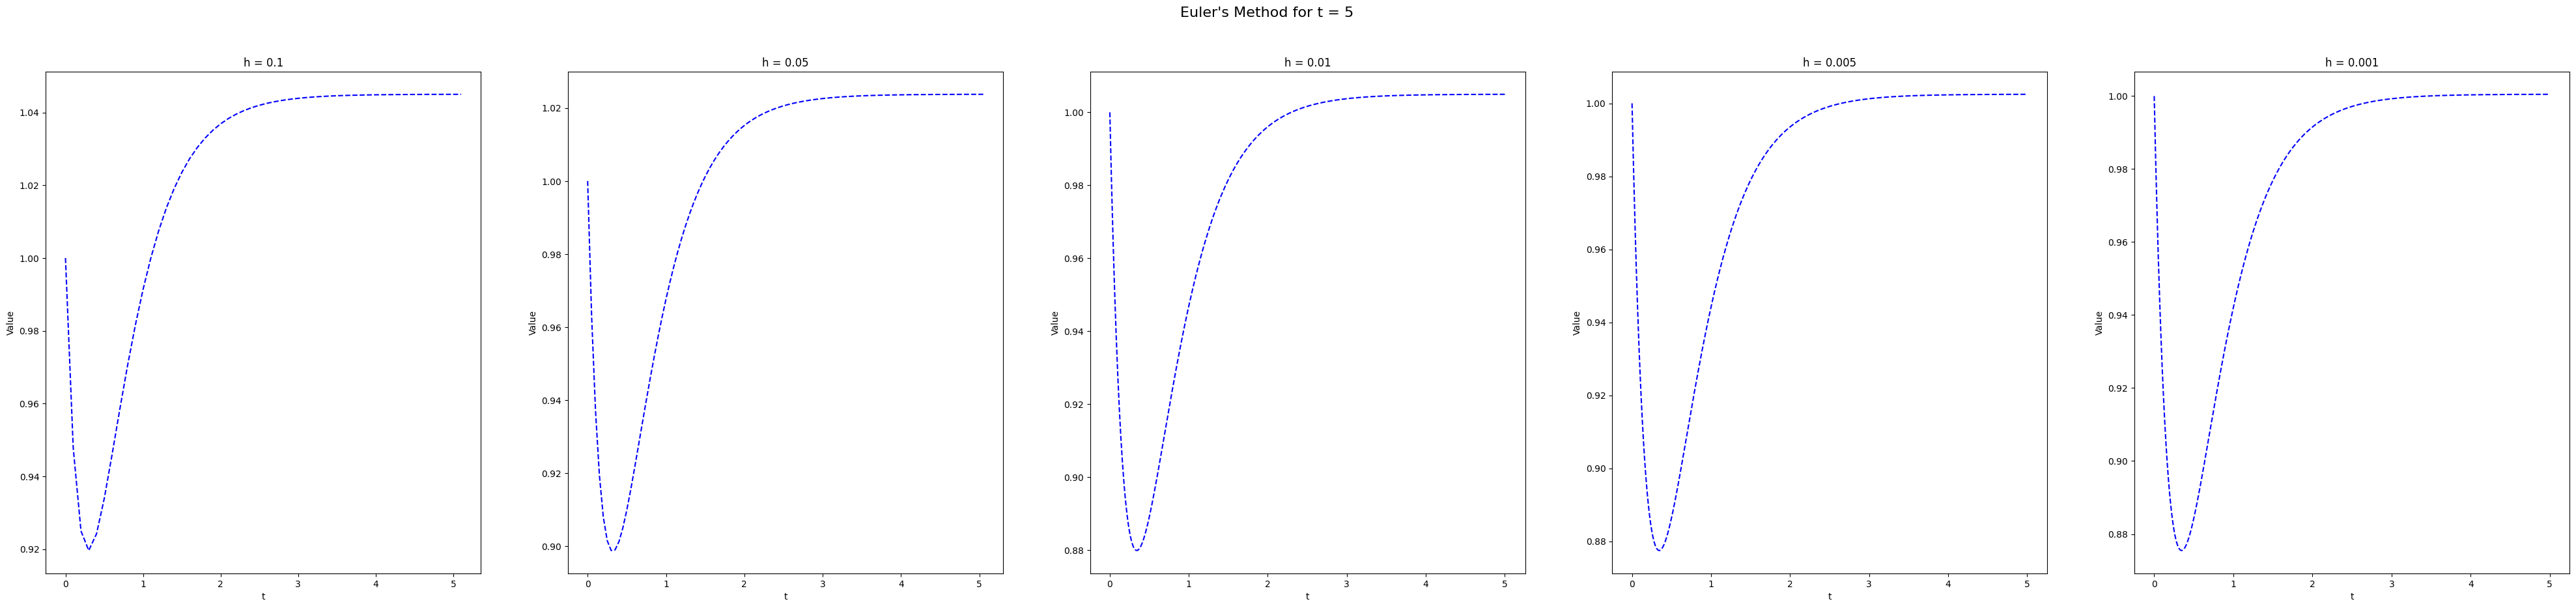

In [65]:
# loop through each target value
for t_value in t_list:
  plot_t(h_values = h_values, t = t_value)

# **Problem 2: Geodesic Shooting Equation**

### Read and visualize data

In [66]:
# All paths are relative. please change the current directory as per your file tree.

# Read in data as a 2, 100, 100 vector field'''
velocity= torch.load('v0.pt').numpy()
print("Dimension of velocity V0: ", velocity.shape)

# Read in data as a 1, 100, 100  image
source= torch.load('source.pt').numpy()
print("Dimension of image: ", source.shape)

Dimension of velocity V0:  (2, 100, 100)
Dimension of image:  (100, 100)


<ipython-input-66-e506a0c0198e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  velocity= torch.load('v0.pt').numpy()
<ipython-input-66-e506a0c0198e>:8: FutureWarning: You 

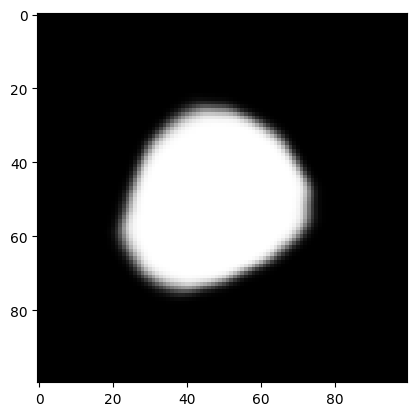

In [67]:
plt.imshow(source, cmap='gray')

### Gradient computation

In [68]:
def forward_difference_x(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[:,1:cols-1] = image[:,1:cols-1] - image[:,0:cols-2];
    d[:,0] = image[:,0] - image[:,cols-1];
    return d


def forward_difference_y(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[1:rows-1,:] = image[1:rows-1,:] - image[0:rows-2,:];
    d[0,:] = image[0,:] - image[rows-1,:];
    return d

def backward_difference_x(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[:,1:cols-1] = image[:,1:cols-1] - image[:,2:cols]
    d[:,-1] = image[:,-1] - image[:,0]
    return d

def backward_difference_y(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[1:rows-1,:] = image[1:rows-1,:] - image[2:rows,:]
    d[-1,:] = image[-1,:] - image[0,:]
    return d

def central_difference_x(image):
    cdif=(forward_difference_x(image)+backward_difference_x(image))/2
    return cdif

def central_difference_y(image):
    cdif=(forward_difference_y(image)+backward_difference_y(image))/2
    return cdif

Grab the initial $\phi$.

In [75]:
# grab the size of the source
source_shape = source.shape
shape_x = source_shape[0]
shape_y = source_shape[1]

x_value = np.linspace(start = 0, stop = 99, num = shape_x)
y_value = np.linspace(start = 0, stop = 99, num = shape_y)

In [82]:
# grab the meshgrid
xv, yv = np.meshgrid(x_value, y_value)